# Seguridad y Privacidad de los Datos - 2024/25

In [1]:
import random
import copy
import time
import torch
import numpy as np
import pandas as pd
import onnxruntime as rt
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

df = pd.read_csv('data/malware_dataset.csv')
df = df.drop(["timestamp", 'unused_permissions', "sha256"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.1, random_state=42)

Using device: cuda


In [3]:
# from ydata_profiling import ProfileReport

# df = pd.read_csv('malware_dataset.csv')
# profile = ProfileReport(df, title='Malware Dataset Report')
# profile.to_file("malware_report.html")

# 0. Train the model on the provided dataset

## **XGBoost**

Accuracy:  0.9806083145172002
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6763
           1       0.93      0.87      0.90       766

    accuracy                           0.98      7529
   macro avg       0.96      0.93      0.95      7529
weighted avg       0.98      0.98      0.98      7529



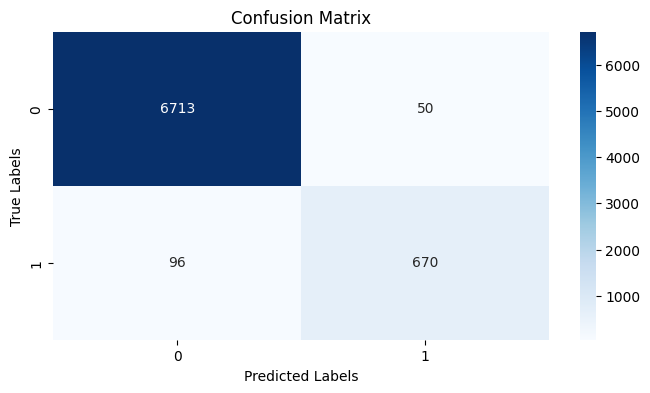

In [4]:
# params: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
xgboost_model = xgb.XGBClassifier(objective='binary:logistic')

xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

xgboost_model.save_model('malware_xgboost_model.json')

In [5]:
# Test model
test_xgboost_model = xgb.XGBClassifier()
test_xgboost_model.load_model('malware_xgboost_model.json')

y_pred2 = xgboost_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred2))

Accuracy:  0.9806083145172002


## **Neural Network**

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(354, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

model = Model().to(device)
dataloader_train = DataLoader(CustomDataset(X_train.values, y_train.values), batch_size=64, shuffle=True)
dataloader_test = DataLoader(CustomDataset(X_test.values, y_test.values), batch_size=64, shuffle=False)

In [ ]:
EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    model.train()
    for data, labels in tqdm(dataloader_train, desc="Training", total=len(dataloader_train)):
        optimizer.zero_grad()
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    for data, labels in tqdm(dataloader_test, desc="Testing", total=len(dataloader_test)):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}/{EPOCHS}, Accuracy: {100 * correct / total:.2f}%")

Testing: 100%|██████████| 118/118 [00:00<00:00, 327.11it/s]


Epoch 1/10, Accuracy: 95.90%


Testing: 100%|██████████| 118/118 [00:00<00:00, 328.60it/s]


Epoch 2/10, Accuracy: 95.58%


Testing: 100%|██████████| 118/118 [00:00<00:00, 373.41it/s]


Epoch 3/10, Accuracy: 96.28%


Testing: 100%|██████████| 118/118 [00:00<00:00, 323.59it/s]


Epoch 4/10, Accuracy: 96.39%


Testing: 100%|██████████| 118/118 [00:00<00:00, 539.93it/s]


Epoch 5/10, Accuracy: 96.53%


Testing: 100%|██████████| 118/118 [00:00<00:00, 568.56it/s]


Epoch 6/10, Accuracy: 96.63%


Testing: 100%|██████████| 118/118 [00:00<00:00, 531.85it/s]


Epoch 7/10, Accuracy: 96.60%


Testing: 100%|██████████| 118/118 [00:00<00:00, 521.30it/s]


Epoch 8/10, Accuracy: 96.61%


Testing: 100%|██████████| 118/118 [00:00<00:00, 551.16it/s]


Epoch 9/10, Accuracy: 96.67%


Testing: 100%|██████████| 118/118 [00:00<00:00, 497.03it/s]

Epoch 10/10, Accuracy: 96.98%


In [8]:
# torch.save(model, 'malware_NN_model.pt')
model = torch.load('malware_NN_model.pt', weights_only=False)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6763
           1       0.89      0.80      0.84       766

    accuracy                           0.97      7529
   macro avg       0.94      0.89      0.91      7529
weighted avg       0.97      0.97      0.97      7529



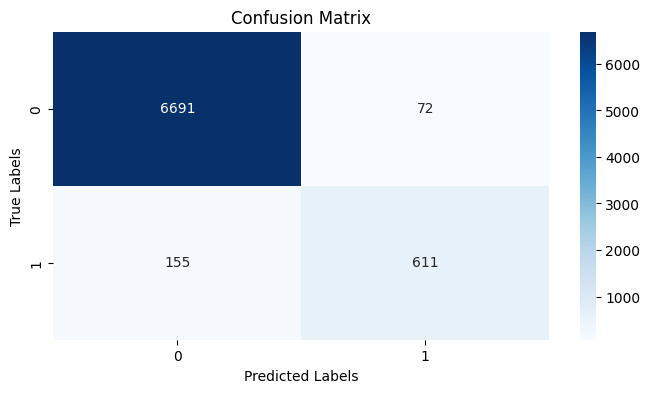

In [9]:
test = X_test.copy()
test= np.array(test)

test = torch.tensor(test, dtype=torch.float32).to(device)
predictions = model(test.to(device))
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.cpu().numpy()

print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 1. Perform at least one black-box attack and one white-box attack on the model. You may perform additional attacks as desired.

## **Black box attack**

In [95]:
test_xgboost_model = xgb.XGBClassifier()
test_xgboost_model.load_model('malware_xgboost_model.json')
x_no_attack = X_test[y_test == 0]
y_no_attack = y_test[y_test == 0]

ypred = test_xgboost_model.predict(np.array(x_no_attack))
ypred = [1 if x > 0.5 else 0 for x in ypred]
print(f"Accuracy: {accuracy_score(y_no_attack, ypred)}")

Accuracy: 0.9923111045394056


In [17]:
lista = []

for i in tqdm(range(1,2000), desc='Iterating over activities count'):
    no_attacks_changed = x_no_attack.copy()
    no_attacks_changed['activities_count'] = i
    ypred = test_xgboost_model.predict(np.array(x_no_attack))
    ypred = [1 if x > 0.5 else 0 for x in ypred]
    lista.append(accuracy_score(y_no_attack, ypred))

Iterating over activities count: 100%|██████████| 1999/1999 [01:14<00:00, 26.73it/s]


In [96]:
n_individuals = 100
n_generations = 10
mutation_rate = 0.1
population = np.random.randint(0, 2000, size=(n_individuals, 8))

class Genetic():
    def __init__(self, population_size: int, model, y_test, X_test):
        self.population = np.random.randint(0, 100, size=(population_size, 8)).tolist()
        self.fitnesses = []
        self.model = model
        self.y_test = y_test
        self.X_test = X_test

    def fitness(self, individual):
        test = self.X_test.copy()
        test[:,0] = individual[0]
        # test[:,1] = individual[1]
        # test[:,2] = individual[2]
        # test[:,3] = individual[3]
        test[:,4] = individual[4]
        test[:,5] = individual[5]
        test[:,6] = individual[6]
        # test[:,7] = individual[7]
        test = torch.tensor(test, dtype=torch.float32).to(device)
        predictions = self.model(test.to(device))
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.cpu().numpy()
        return accuracy_score(self.y_test, predictions)

    def sort_pop(self, reversed: bool) -> tuple[list[list], list]:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = [self.fitness(ind) for ind in self.population]
        lista = sorted(zip(self.population, fitness_list), key=lambda x: x[1], reverse=reversed)
        self.population = [x[0] for x in lista]
        self.fitnesses = [x[1] for x in lista]

    def select(self, T: int) -> list:
        """Return a copy of an individual by tournament selection. Population already ordered by fitness"""
        
        indices = random.choices(range(len(self.population)), k=T)
        best_index = min(indices)  # since population is ordered by fitness
        return copy.deepcopy(self.population[best_index])

    def mutate(self,individual: list[list], pmut: float) -> list:
        """Mutate an individual, swap elements. Return mutated individual"""

        def mutate_swap(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index1, index2 = random.choices(range(len(individual)), k=2)
                individual[index1], individual[index2] = individual[index2], individual[index1]
            return individual

        def mutate_insert(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index_pop, index_insert = random.choices(range(len(individual)), k=2)
                value = individual.pop(index_pop)
                individual.insert(index_insert, value)
            return individual

        def mutate_reverse(individual: list[list], pmut: float) -> list[list]: 
            if random.random() < pmut:
                index1, index2 = sorted(random.sample(range(len(individual)), 2))
                individual[index1:index2 + 1] = individual[index1:index2 + 1][::-1]
            return individual
        def mutate_random(individual: list[list], pmut: float) -> list[list]:
            if random.random()<pmut:
                for index in range(len(individual)):
                    if random.random() < pmut:
                        individual[index] =  np.random.randint(0,100)
            return individual
        
        mutations = [mutate_swap, mutate_insert, mutate_reverse,mutate_random]
        operator = random.choice(mutations)
        return operator(individual, pmut)

    def evolve(self, pmut=0.1, ngen=100, T=2, trace=50, reverse_sort=False, elitism=True) -> None:
        """Evolution procedure"""
        
        size = len(self.population)
        for i in range(ngen):
            new_pop = []
            self.sort_pop(reverse_sort)
            if elitism:
                new_pop.append(self.population[0])
                new_pop.append(self.population[1])
            while len(new_pop) != size:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                mutated1 = self.mutate(individual1, pmut)
                mutated2 = self.mutate(individual2, pmut)
                new_pop.append(mutated1)
                new_pop.append(mutated2)
            
            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(reverse_sort)
                print(f"Num gen: {i}, Fitness óptimo: {self.fitnesses[0]}")
                print(f"Mejor individuo: {self.population[0]}")
            self.population = [*new_pop] # make a copy
        return self.population

start = time.time()
genetic_algorithm = Genetic(population_size=100, model=model, y_test=np.array(y_test), X_test=np.array(X_test)) 
final_population = genetic_algorithm.evolve(pmut=0.1, ngen=10, T=6, trace=1)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo transcurrido: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Num gen: 0, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 1, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 2, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 3, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 4, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 5, Fitness óptimo: 0.13428078098020985
Mejor individuo: [3, 94, 64, 6, 98, 75, 4, 71]
Num gen: 6, Fitness óptimo: 0.11940496745915792
Mejor individuo: [3, 75, 64, 6, 98, 94, 4, 71]
Num gen: 7, Fitness óptimo: 0.11940496745915792
Mejor individuo: [3, 75, 64, 6, 98, 94, 4, 71]
Num gen: 8, Fitness óptimo: 0.11940496745915792
Mejor individuo: [3, 75, 64, 6, 98, 94, 4, 71]
Num gen: 9, Fitness óptimo: 0.11940496745915792
Mejor individuo: [3, 75, 64, 6, 98, 94, 4, 71]
*******Tiempo transcurrido: 0 minutos y 26.58 segu

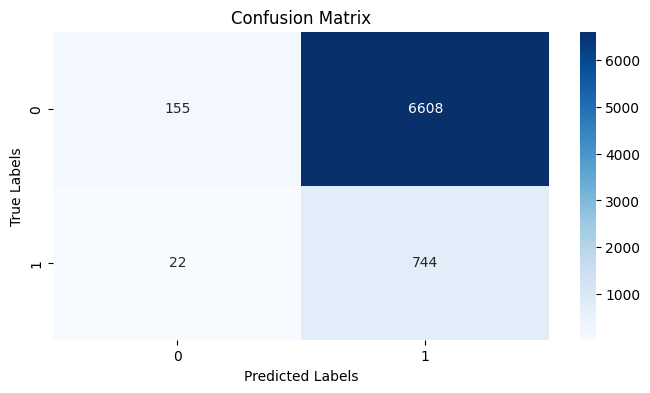

In [ ]:
best_individual = genetic_algorithm.population[0]
test = X_test.copy()
test= np.array(test)
test[:,0] = best_individual[0]
test[:,4] = best_individual[4]
test[:,5] = best_individual[5]
test[:,6] = best_individual[6]

test = torch.tensor(test, dtype=torch.float32).to(device)
predictions = model(test.to(device))
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.cpu().numpy()
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **White Box attack**

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

df = pd.read_csv('data/malware_dataset.csv')
df = df.drop(["timestamp", 'unused_permissions', "sha256"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.1, random_state=42)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

whitebox_model = torch.load('malware_NN_model.pt', weights_only=False).to(device)
whitebox_model.eval()
criterion = nn.CrossEntropyLoss()

Using device: cuda


### FGSM no dirigido

In [12]:
def fgsm_attack(data: torch.Tensor, data_grad: torch.Tensor, epsilon: float = 0.2) -> torch.Tensor:
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, torch.inf)
    perturbed_data[:, 8:] = torch.clamp(perturbed_data[:, 8:], 0, 1)
    perturbed_data = perturbed_data.round()
    return perturbed_data

# Parameters
num_iterations = 5
epsilon = 0.5  # Small step size per iteration

# Start from clean input
x_adv = X_test.clone().detach().to(device)
x_adv.requires_grad = True

for i in range(num_iterations):
    whitebox_model.zero_grad()
    output = whitebox_model(x_adv)
    loss = criterion(output, y_test.long())
    loss.backward()

    # Apply FGSM
    data_grad = x_adv.grad.data
    x_adv = fgsm_attack(x_adv, data_grad, epsilon)

    # Re-enable gradient tracking for the next iteration
    x_adv = x_adv.detach().clone().requires_grad_(True)
    print(f"Accuracy after iteration {i+1}: {accuracy_score(y_test.cpu(), torch.argmax(output, dim=1).cpu())}")

# Final prediction on adversarial example
output = whitebox_model(x_adv)
prediction = torch.argmax(output, dim=1)

Accuracy after iteration 1: 0.9698499136671537
Accuracy after iteration 2: 0.29472705538584143
Accuracy after iteration 3: 0.2806481604462744
Accuracy after iteration 4: 0.28051534068269357
Accuracy after iteration 5: 0.28051534068269357


              precision    recall  f1-score   support

         0.0       0.73      0.31      0.44      6763
         1.0       0.00      0.00      0.00       766

    accuracy                           0.28      7529
   macro avg       0.37      0.16      0.22      7529
weighted avg       0.66      0.28      0.39      7529



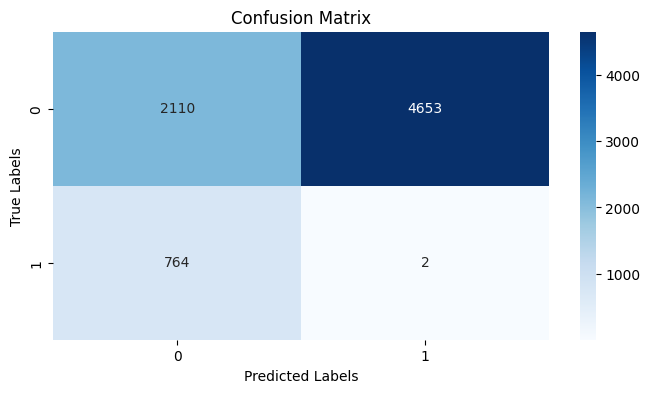

In [13]:
print(classification_report(y_test.cpu(), prediction.cpu()))
cm = confusion_matrix(y_test.cpu(), prediction.cpu())
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
perturbed_data_df = pd.DataFrame(x_adv.cpu().detach().numpy(), columns=df.columns[:-1])
perturbed_data_df['label'] = y_test.cpu().detach().numpy()
perturbed_data_df

,label,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,perm_android.permission.ACCESS_ALL_DOWNLOADS,...,susp_getExternalStorageDirectory,susp_getNetworkCountryIso,susp_getPackageInfo,susp_getSimCountryIso,susp_getSubscriberId,susp_getSystemService,susp_getWifiState,susp_sendTextMessage,susp_setWifiDisabled,susp_setWifiEnabled
0,0.0,0.0,10.0,0.0,10.0,18.0,102.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,8.0,0.0,8.0,24.0,14.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2.0,8.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,8.0,6.0,10.0,22.0,32.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,6.0,2.0,18.0,14.0,48.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7524,0.0,0.0,2.0,0.0,2.0,50.0,12.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7525,0.0,0.0,0.0,4.0,0.0,32.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7526,0.0,0.0,8.0,2.0,18.0,48.0,120.0,12.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7527,1.0,0.0,2.0,0.0,22.0,64.0,100.0,4.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Otros posibles ataques:
* Ataque FGSM dirigido
* Proyectar o iterar (PGD)
* Ataque de Carlini y Wagner (C&W)
* Ataque de Jacobian Saliency Map (JSMA)
* Ataque de DeepFool
* Ataques de Universal Perturbation
* Ataques de Adversarial Noise

# 2. Prove that your model can be more robust to adversarial examples

Demonstrate that your model maintains high accuracy when subjected to adversarial examples. Provide empirical evidence of robustness by evaluating performance under adversarial attacks.

What Will Be Valued:
- Effective adversarial attack methods and proper defense mechanisms.
- Clear evaluation metrics comparing standard vs. adversarial performance.
- Well-documented methodology and reproducibility of results.

In [ ]:
class Large_Model(nn.Module):
    def __init__(self):
        super(Large_Model, self).__init__()
        self.fc1 = nn.Linear(354, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 2)
        
        self.mish = nn.Mish()
    def forward(self, x):
        x = self.fc1(x)
        x = self.mish(x)
        x = self.fc2(x)
        x = self.mish(x)
        x = self.fc3(x)
        x = self.mish(x)
        x = self.fc4(x)
        x = self.mish(x)
        x = self.fc5(x)
        x = self.mish(x)
        x = self.fc6(x)
        return x
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
    
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.1, random_state=42)
    
EPOCHS = 4
BATCH_SIZE = 256
large_model = Large_Model().to(device)
large_dataloader_train = DataLoader(CustomDataset(X_train.values, y_train.values), batch_size=BATCH_SIZE, shuffle=True)
large_dataloader_test = DataLoader(CustomDataset(X_test.values, y_test.values), batch_size=BATCH_SIZE, shuffle=False)
large_optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)
large_criterion = nn.CrossEntropyLoss()

### BlackBox robustness

In [ ]:
for epoch in range(EPOCHS):
    large_model.train()
    for data, labels in tqdm(large_dataloader_train, desc="Training", total=len(large_dataloader_train)):
        large_optimizer.zero_grad()
        data, labels = data.to(device), labels.to(device)
        outputs = large_model(data)
        loss = large_criterion(outputs, labels)
        loss.backward()
        large_optimizer.step()

    correct = 0
    total = 0
    for data, labels in tqdm(large_dataloader_test, desc="Testing", total=len(large_dataloader_test)):
        data, labels = data.to(device), labels.to(device)
        outputs = large_model(data)
        loss = large_criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}/{EPOCHS}, Accuracy: {100 * correct / total:.2f}%")

# torch.save(large_model, 'malware_large_NN_model.pt')

Testing: 100%|██████████| 30/30 [00:00<00:00, 258.22it/s]


Epoch 1/4, Accuracy: 95.25%


Testing: 100%|██████████| 30/30 [00:00<00:00, 257.55it/s]


Epoch 2/4, Accuracy: 96.20%


Testing: 100%|██████████| 30/30 [00:00<00:00, 258.63it/s]


Epoch 3/4, Accuracy: 96.40%


Testing: 100%|██████████| 30/30 [00:00<00:00, 365.35it/s]

Epoch 4/4, Accuracy: 96.23%


In [173]:
large_model = torch.load('malware_large_NN_model.pt', weights_only=False)

Accuracy: 0.8981272413335104
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6763
           1       0.50      0.73      0.59       766

    accuracy                           0.90      7529
   macro avg       0.73      0.82      0.77      7529
weighted avg       0.92      0.90      0.91      7529



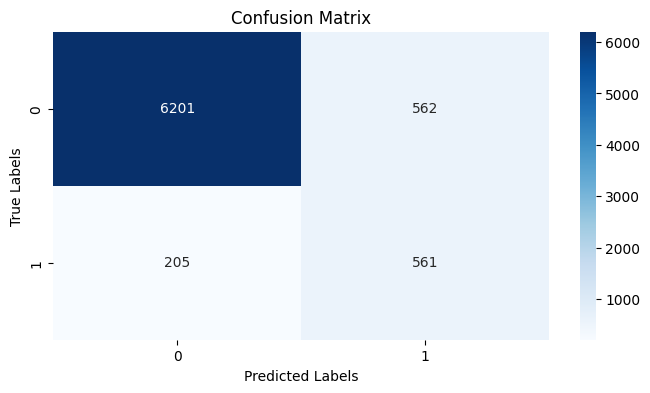

In [193]:
test = X_test.values.copy()
best_individual = [3, 75, 64, 6, 98, 94, 4, 71]
test[:,0] = best_individual[0]
test[:,4] = best_individual[4]
test[:,5] = best_individual[5]
test[:,6] = best_individual[6]

test = torch.tensor(test, dtype=torch.float32).to(device)
predictions = large_model(test.to(device))
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.cpu().numpy()
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Whitebox robustness

Accuracy: 0.6586532075972905
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      6763
           1       0.02      0.06      0.03       766

    accuracy                           0.66      7529
   macro avg       0.45      0.39      0.41      7529
weighted avg       0.79      0.66      0.72      7529



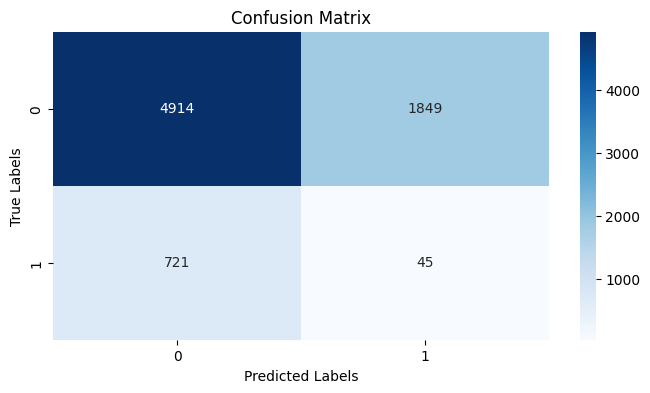

In [ ]:
whitebox_attack = torch.tensor(perturbed_data_df.values.copy(),dtype=torch.float32).to(device)
predictions = large_model(whitebox_attack)
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.cpu().numpy()
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 3. Try to attack this model

You will be given the anonymous model `android_permission_model.onnx`, previously trained on the provided dataset. 
Analyze the model’s weaknesses by testing different black-box attack strategies.

What Will Be Valued:
- Use of diverse adversarial attack techniques.
- Quantitative analysis of attack effectiveness with relevant metrics.
- Clear documentation of the attack process and reproducibility.

Below, you can find an example on model loading and inference. The model expects every column in the dataset except for `sha256`, `timestamp` and `unused_permissions`.
The model is loaded in an [onnx runtime](https://onnxruntime.ai/docs/api/python/api_summary.html). 

## **Model setup**

In [206]:
DATASET_ROUTE = 'data/malware_dataset.csv'
model_path = 'malware_example_model.onnx'

df = pd.read_csv(DATASET_ROUTE)

# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

# features and target separation + train/test split
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Example inference function using [sess.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run):

In [202]:
def onnx_inference(model_path: str, test_data: np.ndarray) -> np.ndarray:
    """
    Function to load and make predictions with an ONNX model
    """
    # open ONNX inference session
    sess = rt.InferenceSession(model_path)
    
    # input and output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    # send inputs to the model and obtain predictions
    results = sess.run(output_names, {input_name: test_data.astype(np.float32)})

    return results[0]       # results[0] are discrete predicted labels, while results[1] are probabilities

ONNX Model Predictions (full test set):
Accuracy: 0.9815
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16943
           1       0.86      0.97      0.91      1880

    accuracy                           0.98     18823
   macro avg       0.93      0.98      0.95     18823
weighted avg       0.98      0.98      0.98     18823



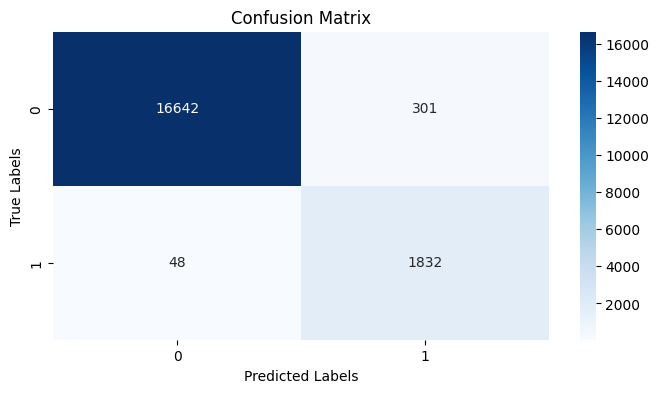

In [209]:
print("ONNX Model Predictions (full test set):")
full_predictions = onnx_inference(model_path, X_test.values)
try:
    print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, full_predictions))
    cm = confusion_matrix(y_test, full_predictions)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Error during ONNX prediction: {e}")

## **Ataque: Copiar los valores del genético para atacar el modelo**

ONNX Model Predictions (full test set):
Accuracy: 0.9498
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     16943
           1       0.71      0.85      0.77      1880

    accuracy                           0.95     18823
   macro avg       0.84      0.91      0.87     18823
weighted avg       0.96      0.95      0.95     18823



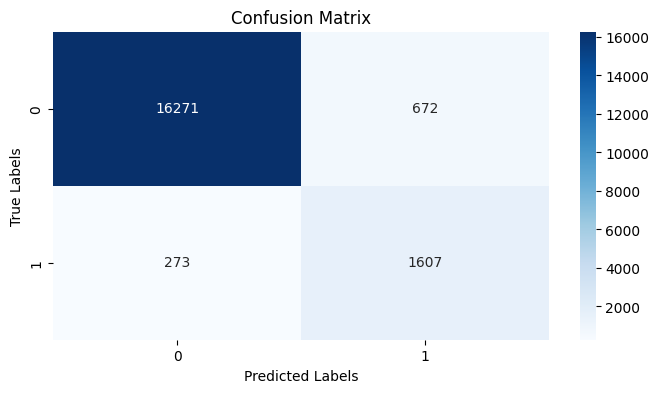

In [ ]:
print("ONNX Model Predictions (full test set):")
test_sample = X_test.copy().values
best_individual = [3, 75, 64, 6, 98, 94, 4, 71]
test_sample[:,0] = best_individual[0]
test_sample[:,4] = best_individual[4]
test_sample[:,5] = best_individual[5]
test_sample[:,6] = best_individual[6]
full_predictions = onnx_inference(model_path, test_sample)
try:
    print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
    print(classification_report(y_test, full_predictions))
    
    cm = confusion_matrix(y_test, full_predictions)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Error during ONNX prediction: {e}")